## Name: 張宸愷
## ID: 0710018

## Introduction
Clickbaits are the links that sounds extremely interesting and you can't resist the urge to click them. 


## Data Collection
I collect my data using Azure Bing News API. I use the API to search for news titles from various different sites. 


## Preprocessing
I remove the punctuations from the title using regex. Convert the titles to lower case. Tokenize the titles using NLTK. Finally, compute the word frequency using NLTK. I also computed some features such as the length of the titles, whether the title starts with a number, is the title in questioning form, etc.


## Models
For this kind of problem, I will use Naive Bayes classifier, random forest, and MLP. 



In [80]:
# Data preprocessing

import sklearn
import numpy as np
import pandas as pd
from nltk import tokenize, ngrams, FreqDist
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# print("sdff")
bait = pd.read_json("bait.json")
non_bait = pd.read_json("not_bait.json")
data = pd.concat([bait, non_bait])
data = [[str.lower(f[0]), f[1]] for f in data.values]

question_phrase = ["what", "when", "where", "are", "is",
                   "how", "why", "can", "should", "could", "were", "was"]
feature_exclamation = ["!" in f[0] for f in data]
feature_isQuestion = []

for f in data:
    s = tokenize.word_tokenize(f[0])
    if len(s) == 0:
        feature_isQuestion.append(False)
        continue
    feature_isQuestion.append("?" in str(f[0]) or (s[0] in question_phrase))
d = []
for f in data:
    s = re.sub(r"[?!`~'\-=\+@/;:\".,_@#$%^&]+", "", f[0])
    d.append([s, f[1]])
data = d
data = pd.DataFrame([[tokenize.word_tokenize(f[0]), f[1]] for f in d])
feature_length = pd.Series([len(f[0]) for f in data.values])

# print(feature_length)

all_counts = [[], [], []]
for i in data.values:
    for size in range(3):
        all_counts[size] += (ngrams(i[0], size+1))
freq = list(range(3))
for size in range(3):
    freq[size] = FreqDist(all_counts[size])

features = pd.DataFrame()
features[0] = [(1 if f else 0) for f in feature_exclamation]
features[1] = [(1 if f else 0) for f in feature_isQuestion]
features[2] = feature_length
cv = CountVectorizer(max_features=200, ngram_range=(1, 3))
cv_fit = cv.fit_transform([f[0] for f in d]).toarray()
# print(cv_fit.toarray().shape)
# print(cv.get_feature_names_out())
features = pd.concat([features, pd.DataFrame(cv_fit), pd.Series([f[1] for f in data.values])],axis=1)
print(features)
features = features.to_numpy()

      0    1    2    0    1    2    3    4    5    6    ...  191  192  193  \
0       0    0   18    0    0    0    0    1    0    0  ...    0    0    0   
1       0    0   11    0    0    0    0    0    0    0  ...    0    0    0   
2       0    0   24    0    0    1    0    0    0    0  ...    0    0    0   
3       0    0   11    0    0    0    0    0    0    0  ...    0    0    0   
4       0    0   11    0    0    0    0    0    0    0  ...    0    0    0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4710    0    0   15    0    0    0    0    0    0    0  ...    0    0    0   
4711    0    1   13    0    0    0    0    0    0    0  ...    0    0    0   
4712    0    0   12    0    1    0    0    0    0    0  ...    0    0    0   
4713    0    0   14    0    0    0    0    0    0    0  ...    0    0    0   
4714    0    0   13    0    0    0    0    0    0    0  ...    0    1    0   

      194  195  196  197  198  199  0    
0       0    0    0  

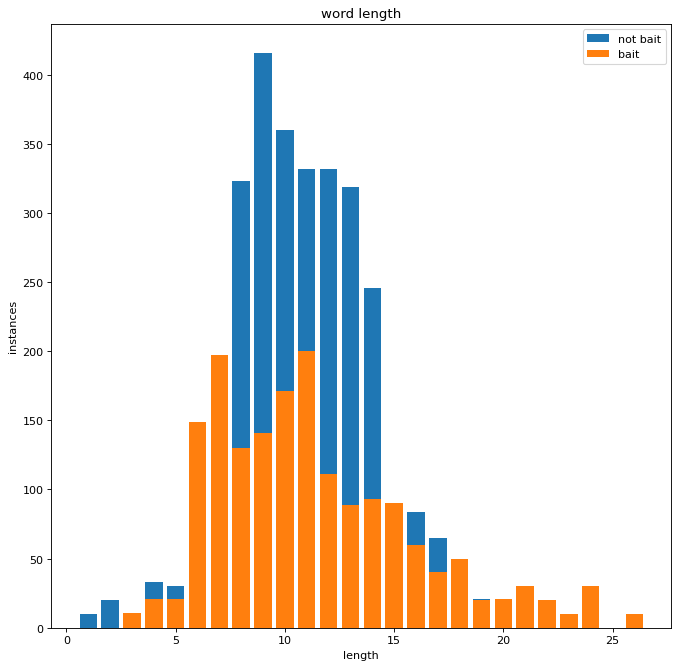

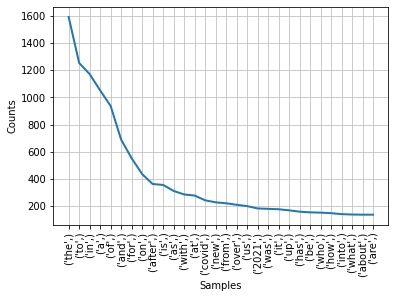

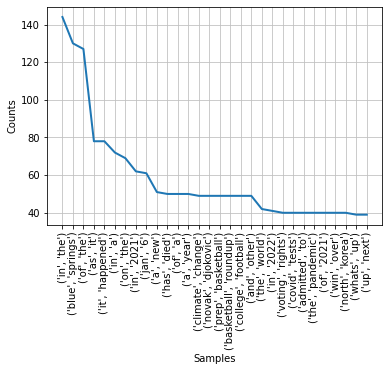

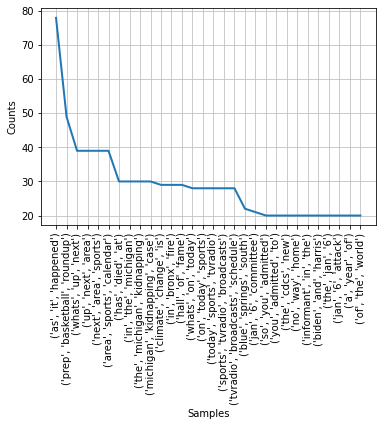

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [82]:
# Data visualization

import matplotlib.pyplot as plt

select_bait = (data[1] == 1)
select_not = (data[1] == 0)
_ = plt.figure(figsize=(10, 10), dpi=80)
bait:pd.Series = feature_length[select_bait].value_counts()
not_bait:pd.Series = feature_length[select_not].value_counts()
_ = plt.bar(not_bait.index.values, not_bait.values, label="not bait")
_ = plt.bar(bait.index.values, bait.values, label="bait")
plt.legend()
plt.title("word length")
plt.xlabel("length")
plt.ylabel("instances")

_ = plt.figure()
freq[0].plot(30)
freq[1].plot(30)
freq[2].plot(30)



In [87]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


train_X, test_X, train_y, test_y = train_test_split(features[:, 0:-2], features[:, -1:].reshape(-1), train_size=0.7)

rfc = RandomForestClassifier()
rfc.fit(train_X, train_y)
pred_y = rfc.predict(test_X)
r = classification_report(test_y, pred_y)
confm = confusion_matrix(test_y, pred_y)

print(r)
print(confm)





              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       0.99      0.99      0.99       512

    accuracy                           1.00      1415
   macro avg       0.99      0.99      0.99      1415
weighted avg       1.00      1.00      1.00      1415

[[899   4]
 [  3 509]]


# Conclusion